# Analysis of M66

Date: 23 April 2025

In [1]:
import os
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astroquery.mast import Observations
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip, mad_std
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from photutils.utils import calc_total_error
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import Background2D, MedianBackground

from XRBID.Sources import LoadSources, NewSources, GetCoords
from XRBID.WriteScript import WriteReg
from XRBID.AutoPhots import RunPhots # Photometry
from XRBID.DataFrameMod import (Find, RemoveElse, FindUnique,
                                BuildFrame)
from XRBID.Align import CorrectAstrometry, CalcPU, AlignReg # Astrometry

In [2]:
cd = os.chdir
workdir = "/Users/undergradstudent/Research/XRB-Analysis/Notebooks"
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/HST/M66" # previously used as datadir
chandradir = "/Users/undergradstudent/Research/XRB-Analysis/Chandra/M66"

In [5]:
%%time

print("Finding observations for WFC3/UVIS images...")
obs_table = Observations.query_criteria(objectname="M66", obs_collection="HST",
                                        filters=["F555W", "F814W", "F336W", "F438W", "F275W"],
                                        proposal_id=[11364, 13477, 15654, 12968],
                                        instrument_name="WFC3/UVIS")
print("Done")

Finding observations for WFC3/UVIS images...
Done
CPU times: user 29.2 ms, sys: 5.92 ms, total: 35.1 ms
Wall time: 23.4 s


In [7]:
cd /Users/undergradstudent/Research/XRB-Analysis/HST/M66

/Users/undergradstudent/Research/XRB-Analysis/HST/M66


In [9]:
print("Downloading data.\n This may take several minutes... \n")
products = Observations.get_product_list(obs_table)
data_prod = ['FLC']       # other options are ['FLT','DRC','DRZ']
data_type = ['HAP-SVM']   # other options are ['CALACS','CALWF3','CALWP2']

Observations.download_products(products, project=data_type, 
                               productSubGroupDescription=data_prod)
print("Done")


 This may take several minutes... 

INFO: 37 of 74 products were duplicates. Only returning 37 unique product(s). [astroquery.mast.utils]
Done


In [10]:
# Gathering the FLC file names
input_flcs = glob.glob(os.path.join('mastDownload','HST','*','*.fits'))

# Moving files from mastDownload directory into current directory
for flc in input_flcs:
  shutil.copy(flc, os.path.basename(flc))

shutil.rmtree('mastDownload') # removes the extra directories
print("Done")

Done


In [12]:
# The filename format searched below will need to be changed based on the 
# names of the files downloaded above
flc_files = glob.glob("hst*_acs_wfc_*_j*_flc.fits")
flc_files.sort()       # Alphabetizing files

for i,f in enumerate(flc_files):
    try: hdu = fits.open(f)
    except: print(f,"not good. Please remove.")

print("Done")

Done


In [ ]:
from drizzlepac import tweakreg
import glob

flc_files = glob.glob("hst*_wfc3_uvis_f814w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

In [ ]:
tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=True, writecat=True, 
                  enforce_user_order=False, 
                  fitgeometry='rscale', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f555w.txt', 
                  updatehdr=False)

In [ ]:
Woohoo! It worked! Let's see how the shifts look like:

In [2]:
cd /Users/undergradstudent/Research/XRB-Analysis/HST/M66

/Users/undergradstudent/Research/XRB-Analysis/HST/M66


In [3]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

In [4]:
shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f814w_ic0h01mx_flc.fits,0.36,0.75,0.008,1.00005,0.34,0.19
hst_12968_01_wfc3_uvis_f814w_ic0h01mz_flc.fits,0.44,0.10,359.995,1.00023,0.32,0.14
hst_12968_01_wfc3_uvis_f814w_ic0h01n7_flc.fits,0.56,0.60,0.001,1.00010,0.34,0.33
hst_12968_01_wfc3_uvis_f814w_ic0h01n8_flc.fits,0.63,0.64,359.997,1.00007,0.33,0.29
hst_13477_03_wfc3_uvis_f814w_ic8503wh_flc.fits,0.79,0.81,0.000,0.99999,0.41,0.42
hst_13477_03_wfc3_uvis_f814w_ic8503wj_flc.fits,0.69,0.71,0.002,0.99999,0.50,0.51
hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits,0.00,0.00,0.000,1.00000,0.00,0.00
hst_15654_22_wfc3_uvis_f814w_idxr22ek_flc.fits,0.82,0.80,0.002,0.99999,0.48,0.42
hst_15654_22_wfc3_uvis_f814w_idxr22ew_flc.fits,0.76,0.90,0.003,1.00000,0.44,0.41


In [ ]:
tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f555w.txt', 
                  updatehdr=False)
# started at 3:53 pm

In [6]:
pwd

'/Users/undergradstudent/Research/XRB-Analysis/HST/M66'

In [7]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

In [8]:
shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f814w_ic0h01mx_flc.fits,1.04,0.75,0.000,1.00000,0.43,0.61
hst_12968_01_wfc3_uvis_f814w_ic0h01mz_flc.fits,0.97,0.88,0.000,1.00000,0.45,0.41
hst_12968_01_wfc3_uvis_f814w_ic0h01n7_flc.fits,0.89,0.94,0.000,1.00000,0.45,0.48
hst_12968_01_wfc3_uvis_f814w_ic0h01n8_flc.fits,0.62,1.00,0.000,1.00000,0.55,0.41
hst_13477_03_wfc3_uvis_f814w_ic8503wh_flc.fits,0.48,0.49,0.000,1.00000,0.51,0.51
hst_13477_03_wfc3_uvis_f814w_ic8503wj_flc.fits,0.70,0.68,0.000,1.00000,0.50,0.51
hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits,0.00,0.00,0.000,1.00000,0.00,0.00
hst_15654_22_wfc3_uvis_f814w_idxr22ek_flc.fits,0.94,0.70,0.000,1.00000,0.52,0.50
hst_15654_22_wfc3_uvis_f814w_idxr22ew_flc.fits,0.72,0.87,0.000,1.00000,0.51,0.52


In [ ]:
from drizzlepac.astrodrizzle import AstroDrizzle as adriz

adriz(flc_files, output='M66_mosaic_acs_f814w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

The drizzled image looks amazing!

In [2]:
cd /Users/undergradstudent/Research/XRB-Analysis/HST/M66

/Users/undergradstudent/Research/XRB-Analysis/HST/M66


In [7]:
import glob
flc_files = glob.glob("hst*_wfc3_uvis_f555w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

In [ ]:
from drizzlepac import tweakreg

tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='rscale', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f555w.txt', 
                  updatehdr=False)

In [11]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f555w_ic0h01mn_flc.fits,0.46,1.09,0.009,1.00007,0.57,0.38
hst_12968_01_wfc3_uvis_f555w_ic0h01mo_flc.fits,0.91,0.87,359.989,0.99977,0.46,0.44
hst_12968_01_wfc3_uvis_f555w_ic0h01mv_flc.fits,1.30,0.01,359.970,1.00011,0.41,0.51
hst_12968_01_wfc3_uvis_f555w_ic0h01mw_flc.fits,-2.12,0.72,0.059,1.00067,0.44,0.48
hst_13477_03_wfc3_uvis_f555w_ic8503wc_flc.fits,0.32,0.50,0.004,1.00001,0.46,0.49
hst_13477_03_wfc3_uvis_f555w_ic8503wd_flc.fits,0.66,0.70,0.002,0.99994,0.52,0.50
hst_13477_03_wfc3_uvis_f555w_ic8503wf_flc.fits,0.58,0.63,0.002,0.99997,0.51,0.51
hst_15654_22_wfc3_uvis_f555w_idxr22eu_flc.fits,0.69,0.75,0.002,1.00001,0.52,0.52
hst_15654_22_wfc3_uvis_f555w_idxr22f7_flc.fits,0.93,0.68,0.004,0.99994,0.49,0.51


Since the rotation is quite small, I will rerun tweakreg with `fitgeometry='shift'`

In [ ]:
tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f555w.txt', 
                  updatehdr=False)

In [12]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f555w_ic0h01mn_flc.fits,0.81,1.03,0.000,1.00000,0.56,0.40
hst_12968_01_wfc3_uvis_f555w_ic0h01mo_flc.fits,0.32,0.66,0.000,1.00000,0.48,0.44
hst_12968_01_wfc3_uvis_f555w_ic0h01mv_flc.fits,0.55,0.89,0.000,1.00000,0.48,0.49
hst_12968_01_wfc3_uvis_f555w_ic0h01mw_flc.fits,0.57,0.65,0.000,1.00000,0.51,0.53
hst_13477_03_wfc3_uvis_f555w_ic8503wc_flc.fits,0.37,0.44,0.000,1.00000,0.46,0.50
hst_13477_03_wfc3_uvis_f555w_ic8503wd_flc.fits,0.63,0.64,0.000,1.00000,0.52,0.51
hst_13477_03_wfc3_uvis_f555w_ic8503wf_flc.fits,0.57,0.60,0.000,1.00000,0.51,0.51
hst_15654_22_wfc3_uvis_f555w_idxr22eu_flc.fits,0.71,0.73,0.000,1.00000,0.52,0.52
hst_15654_22_wfc3_uvis_f555w_idxr22f7_flc.fits,0.89,0.62,0.000,1.00000,0.49,0.51


In [ ]:
from drizzlepac.astrodrizzle import AstroDrizzle as adriz

adriz(flc_files, output='M66_mosaic_acs_f555w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

This looks good too!

In [ ]:
import glob
flc_files = glob.glob("hst*_wfc3_uvis_f336w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

from drizzlepac import tweakreg

tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f336w.txt', 
                  updatehdr=False)

In [13]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f555w_ic0h01mn_flc.fits,0.81,1.03,0.000,1.00000,0.56,0.40
hst_12968_01_wfc3_uvis_f555w_ic0h01mo_flc.fits,0.32,0.66,0.000,1.00000,0.48,0.44
hst_12968_01_wfc3_uvis_f555w_ic0h01mv_flc.fits,0.55,0.89,0.000,1.00000,0.48,0.49
hst_12968_01_wfc3_uvis_f555w_ic0h01mw_flc.fits,0.57,0.65,0.000,1.00000,0.51,0.53
hst_13477_03_wfc3_uvis_f555w_ic8503wc_flc.fits,0.37,0.44,0.000,1.00000,0.46,0.50
hst_13477_03_wfc3_uvis_f555w_ic8503wd_flc.fits,0.63,0.64,0.000,1.00000,0.52,0.51
hst_13477_03_wfc3_uvis_f555w_ic8503wf_flc.fits,0.57,0.60,0.000,1.00000,0.51,0.51
hst_15654_22_wfc3_uvis_f555w_idxr22eu_flc.fits,0.71,0.73,0.000,1.00000,0.52,0.52
hst_15654_22_wfc3_uvis_f555w_idxr22f7_flc.fits,0.89,0.62,0.000,1.00000,0.49,0.51


In [ ]:
adriz(flc_files, output='M66_mosaic_acs_f336w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

In [ ]:
flc_files = glob.glob("hst*_wfc3_uvis_f438w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f438w.txt', 
                  updatehdr=False)

In [17]:
shift_table = Table.read('M66_shifts_acs_f438w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f438w_ic0h01mj_flc.fits,0.79,0.84,0.000,1.00000,0.52,0.40
hst_12968_01_wfc3_uvis_f438w_ic0h01mk_flc.fits,0.80,1.29,0.000,1.00000,0.45,0.54
hst_12968_01_wfc3_uvis_f438w_ic0h01ml_flc.fits,0.44,0.56,0.000,1.00000,0.55,0.51
hst_12968_01_wfc3_uvis_f438w_ic0h01mm_flc.fits,1.20,0.75,0.000,1.00000,0.46,0.50
hst_15654_22_wfc3_uvis_f438w_idxr22em_flc.fits,0.56,0.63,0.000,1.00000,0.51,0.49
hst_15654_22_wfc3_uvis_f438w_idxr22ez_flc.fits,0.47,0.40,0.000,1.00000,0.54,0.50
hst_15654_22_wfc3_uvis_f438w_idxr22fc_flc.fits,0.82,0.79,0.000,1.00000,0.53,0.50


In [ ]:
adriz(flc_files, output='M66_mosaic_acs_f438w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

In [ ]:
flc_files = glob.glob("hst*_wfc3_uvis_f275w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

In [ ]:
tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f275w.txt', 
                  updatehdr=False)

This worked! Need to see the outputs!

In [6]:
from astropy.table import Table
shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f555w_ic0h01mn_flc.fits,0.81,1.03,0.000,1.00000,0.56,0.40
hst_12968_01_wfc3_uvis_f555w_ic0h01mo_flc.fits,0.32,0.66,0.000,1.00000,0.48,0.44
hst_12968_01_wfc3_uvis_f555w_ic0h01mv_flc.fits,0.55,0.89,0.000,1.00000,0.48,0.49
hst_12968_01_wfc3_uvis_f555w_ic0h01mw_flc.fits,0.57,0.65,0.000,1.00000,0.51,0.53
hst_13477_03_wfc3_uvis_f555w_ic8503wc_flc.fits,0.37,0.44,0.000,1.00000,0.46,0.50
hst_13477_03_wfc3_uvis_f555w_ic8503wd_flc.fits,0.63,0.64,0.000,1.00000,0.52,0.51
hst_13477_03_wfc3_uvis_f555w_ic8503wf_flc.fits,0.57,0.60,0.000,1.00000,0.51,0.51
hst_15654_22_wfc3_uvis_f555w_idxr22eu_flc.fits,0.71,0.73,0.000,1.00000,0.52,0.52
hst_15654_22_wfc3_uvis_f555w_idxr22f7_flc.fits,0.89,0.62,0.000,1.00000,0.49,0.51


In [ ]:
adriz(flc_files, output='M66_mosaic_acs_f275w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

Date: 24 April 2025

I was successful with creating the mosaics and the alignment also looks pretty good. I need to show these results to Qiana and see if things look good. 

Since my initial goal was mosaicking was to learn the procedure for creating mosaics, I had not downloaded the Chandra data. That is what I am going to do now. 

# Astrometric Corrections

Date: May 5 <br>
I am still experimenting with astrometric corrections to work. 

My strategy is going to be the following:
1. Apply the same change in coordinates to all the chandra sources
2. Perform astrometric corrections on those coordinates!

In [69]:
# Creating the region file of all the sources with the shifted coordinates
M66_CSC = LoadSources(chandradir+"/cscresults_M66_renamed.frame")
M66_unique = FindUnique(M66_CSC, header="CSC ID")
M66_unique["RA"] = M66_unique["RA"] - 0.000008
M66_unique["Dec"] = M66_unique["Dec"] + 0.000027
WriteReg(M66_unique, outfile=chandradir+"/M66_cscsources_shifted.reg", idname="CSC ID", 
         radius=5, width=2, color="hotpink", showlabel=True)

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/cscresults_M66_renamed.frame...
Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_cscsources_shifted.reg


This looks pretty good on DS9!

In [70]:
M66_calibrators = ['2CXO J112018.9+130135',
                   '2CXO J112018.3+125900',
                   '2CXO J112014.8+125814',
                   '2CXO J112013.0+125736']

print(len(M66_calibrators), "calibrators to match...")

# Using DataFrameMod.RemoveElse() to remove all but the sources above from the DataFrame
M66_calibrators = RemoveElse(M66_unique, keep=M66_calibrators, header="CSC ID")
print(len(M66_calibrators), "calibrators found.")

# Saving these as a region file, in case we want to double-check
WriteReg(M66_calibrators, outfile=chandradir+"/M66_calibrators.reg",
         radius=25, width=2)

4 calibrators to match...
4 calibrators found.
Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_calibrators.reg


Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/HST/M66/M66_daofind_f555w_wfc3_fk5.reg


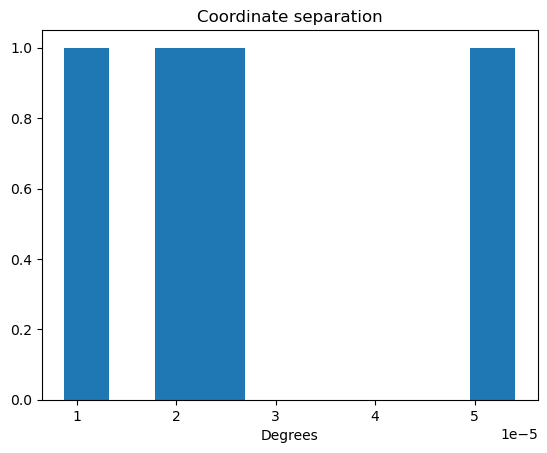

Median separation: 2.367180177845239e-05


Input min and max separation: 0.9e-5, 5.4e-5


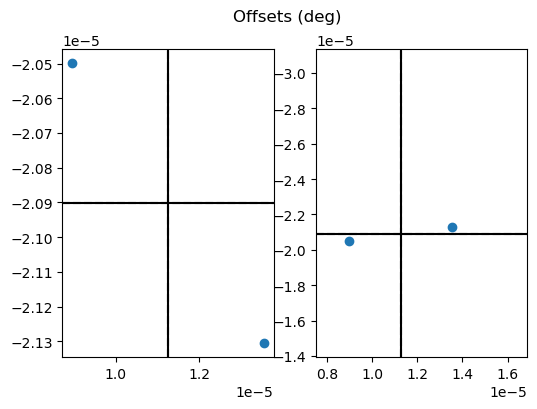

Median offsets in x and y (deg): 1.1251252786337318e-05 -2.0901841101483853e-05


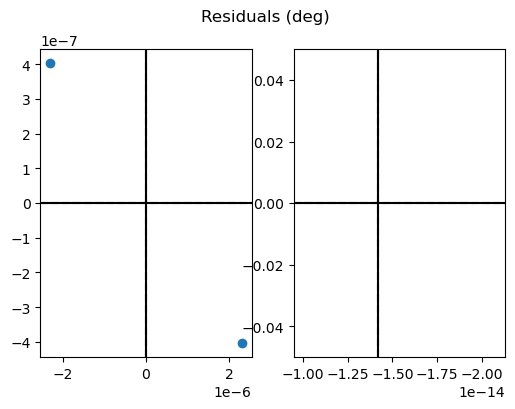


RESULTS OF ASTROMETRY CORRECTION

Median offsets in x and y:
 1.1251252786337318e-05 -2.0901841101483853e-05 degrees
 0.040504510030814345 -0.07524662796534187 arcsecs

Standard deviation in x and y offsets:
 2.305326276541564e-06 4.036772933702082e-07 degrees
 0.00829917459554963 0.0014532382561327495 arcsecs

Saving /Users/undergradstudent/Research/XRB-Analysis/HST/M66/M66_astrocorrect.reg
Check region file for correct assessments.


(np.float64(1.1251252786337318e-05),
 np.float64(-2.0901841101483853e-05),
 np.float64(2.305326276541564e-06),
 np.float64(4.036772933702082e-07))

In [72]:
# Perform astrometric corrections
# Setting up the base and the catalog coordinates for CorrectAstrometry
base_coords = GetCoords(hstdir+"/M66_daofind_f555w_wfc3_fk5.reg")
cat_coords = [M66_calibrators["RA"].values.tolist(), 
              M66_calibrators["Dec"].values.tolist()]

# Running CorrectAstrometry
CorrectAstrometry(base_coords, cat_coords, returnshifts=True, \
                  savebasereg=hstdir+"/M66_astrocorrect.reg")

## Calculating Positional Uncertainty

In [82]:
sig1, sig2 = CalcPU(M66_unique, std=[0.0083,0.014], sig2search="Err Ellipse Major") # std in arcsecs

In [83]:
M66_unique['1Sig'] = sig1  # Saves sig1 to a new header called '1Sig'
M66_unique['2Sig'] = sig2 

display(M66_unique)

M66_unique.to_csv(chandradir+'/M66_csc_astrocorrected.frame')

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig
0,0.603512,2CXO J112014.9+125929,170.062420,12.991522,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641,0.065813,0.145823
1,1.154310,2CXO J112015.0+125928,170.062870,12.991356,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784,0.071113,0.161211
2,4.249587,2CXO J112014.9+125933,170.062251,12.992660,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017,0.063602,0.140304
3,4.484088,2CXO J112015.2+125932X,170.063657,12.992216,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.723288,3.446575
4,5.940189,2CXO J112015.3+125932,170.064111,12.992257,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197,0.121715,0.288759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127449,13.003690,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527,0.428885,1.054849
84,237.496980,2CXO J112008.5+130307,170.035391,13.051941,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982,0.412499,1.004848
85,240.218881,2CXO J112019.6+130320,170.081728,13.055597,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744,0.169920,0.357868
86,246.797558,2CXO J112027.8+125649,170.116105,12.947026,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118,0.426337,1.050268


## Selecting the best 2-$\sigma$ radius per source

In [84]:
# Pulling the ID of each unique CSC source
ids = FindUnique(M66_unique, header="CSC ID")["CSC ID"].values.tolist()

# Building an empty DataFrame, which I will fill below
M66_best = BuildFrame()

for i in ids: # for each unique ID pulled from CSC...
    
    # Search for all instances (i.e. observations) of each source
    Temp = Find(M66_unique, "CSC ID = " + i)
    
    # Try to avoid sources where counts = NaN (invalid observations) 
    if len(Find(Temp, ["Counts != NaN", "Theta != NaN"])) > 0: 
        Temp = Find(Temp, ["Counts != NaN", "Theta != NaN"])
    
    # Specifically focus on those with a valid number of counts
    if len(Find(Temp, "Counts > 0")) > 0: 
        Temp = Find(Temp, ["Counts > 0"])
        
    # Otherwise, all instances with counts = 0 have the same measurements, 
    # so it doesn't matter which row is chosen for the best radii
    else: pass;
    
    # Take the source with the smallest 2sig. 
    # If there's more than one, take the first on the list.
    Tempbest = Find(Temp, "2Sig =< " + str(min(Temp["2Sig"]))).iloc[:1]
    
    # Add the chosen source observation to the new DataFrame
    M66_best = pd.concat([M66_best, Tempbest], ignore_index=True)

# Saving results to a DataFrame file
# This file contains only rows from M101_CSC that has the 
# best 2sigma radius, based on the search performed above
M66_best.to_csv(chandradir+"/M66_csc_bestrads.frame")

display(M66_best)

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig
0,0.603512,2CXO J112014.9+125929,170.062420,12.991522,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641,0.065813,0.145823
1,1.154310,2CXO J112015.0+125928,170.062870,12.991356,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784,0.071113,0.161211
2,4.249587,2CXO J112014.9+125933,170.062251,12.992660,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017,0.063602,0.140304
3,4.484088,2CXO J112015.2+125932X,170.063657,12.992216,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.723288,3.446575
4,5.940189,2CXO J112015.3+125932,170.064111,12.992257,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197,0.121715,0.288759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127449,13.003690,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527,0.428885,1.054849
84,237.496980,2CXO J112008.5+130307,170.035391,13.051941,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982,0.412499,1.004848
85,240.218881,2CXO J112019.6+130320,170.081728,13.055597,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744,0.169920,0.357868
86,246.797558,2CXO J112027.8+125649,170.116105,12.947026,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118,0.426337,1.050268


## Saving the positional uncertainties as region files

In [85]:
# Saving the 1 and 2 sigma region files for DS9 use.
# The 2sig region files have the CSC ID printed above each source.
WriteReg(M66_best, radius=M66_best['2Sig'].values.tolist(), radunit='arcsec', \
         idname="CSC ID", showlabel=True, outfile=chandradir+'/M66_bestrads_2sig.reg')
WriteReg(M66_best, radius=M66_best['1Sig'].values.tolist(), radunit='arcsec', \
         outfile=chandradir+'/M66_bestrads_1sig.reg')

Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_bestrads_2sig.reg
Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_bestrads_1sig.reg
